In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import loguniform

In [2]:
data_raw = pd.read_csv('data/cleaned_data.csv', index_col=0, parse_dates=['author_date_of_birth', 'publication_date'])

# Feature engineering

In [3]:
data_raw['description_length'] = data_raw['description'].str.len()

In [4]:
data_raw['number_of_pages'] = data_raw['number_of_pages'].astype(int)

In [5]:
categorical_features = ['language', 'category', 'format']

In [6]:
data_raw['language'].unique()

array(['polski', 'angielski', 'niemiecki'], dtype=object)

In [7]:
le = LabelEncoder()
for cat in categorical_features:
    data_raw[cat] = le.fit_transform(data_raw[cat])

In [8]:
rating_features = [f'rating_{i}' for i in range(1, 11)]
scaled_features = [f'scaled_{element}' for element in rating_features]
normalized_features = [f'normalized_{element}' for element in rating_features]

In [9]:
# to be predicted
threshold = 2000
data_raw['bestseller'] = (data_raw['number_of_people_has'] >= threshold).astype(int)

In [10]:
data_raw.loc[69, ['number_of_people_has', 'bestseller']]

number_of_people_has    4501.0
bestseller                   1
Name: 69, dtype: object

In [11]:
scaler = MinMaxScaler((0, 1))

In [12]:
data_raw = data_raw.loc[data_raw[rating_features].any(axis=1) > 0]

In [13]:
# scaling ratings
data_raw[scaled_features] = scaler.fit_transform(data_raw[rating_features])

In [14]:
# normalized features
data_raw[normalized_features] = (data_raw[rating_features].T/data_raw[rating_features].sum(axis=1)).T

<Axes: >

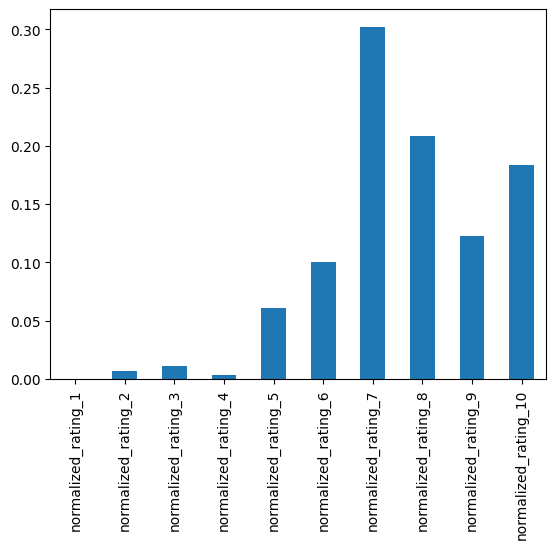

In [15]:
data_raw.loc[12000, normalized_features].plot.bar()

In [16]:
data = data_raw.drop(['number_of_user_opinions', 'number_of_user_opinions', 'number_of_user_ratings', 'number_of_discussions', 'number_of_people_read', 'number_of_people_has', 'number_of_people_favorite', 'number_of_people_currently_read', 'number_of_people_wants_to_read', 'number_of_people_wants_as_gift', 'number_of_people_currently_read', 'description', 'series', 'publication_date', 'author_date_of_birth'], axis=1)

In [17]:
# Assuming data and rating_features are already defined
total_ratings = data[rating_features].sum(axis=1)
rating_weights = np.arange(1, 11)

# mean rating
data['mean_rating'] = (data[rating_features] * rating_weights).sum(axis=1) / total_ratings

# standard deviation
mean_rating_array = data['mean_rating'].to_numpy()
data['std_rating'] = np.sqrt(((data[rating_features] * (rating_weights - mean_rating_array[:, None]) ** 2).sum(axis=1)) / total_ratings)

# skewness
data['skewness'] = ((data[rating_features] * (rating_weights - mean_rating_array[:, None]) ** 3).sum(axis=1)) / (total_ratings * data['std_rating'] ** 3)

# kurtosis
data['kurtosis'] = ((data[rating_features] * (rating_weights - mean_rating_array[:, None]) ** 4).sum(axis=1)) / (total_ratings * data['std_rating'] ** 4) - 3

In [18]:
correlation_matrix = data.drop(rating_features + normalized_features + scaled_features, axis=1).corr()

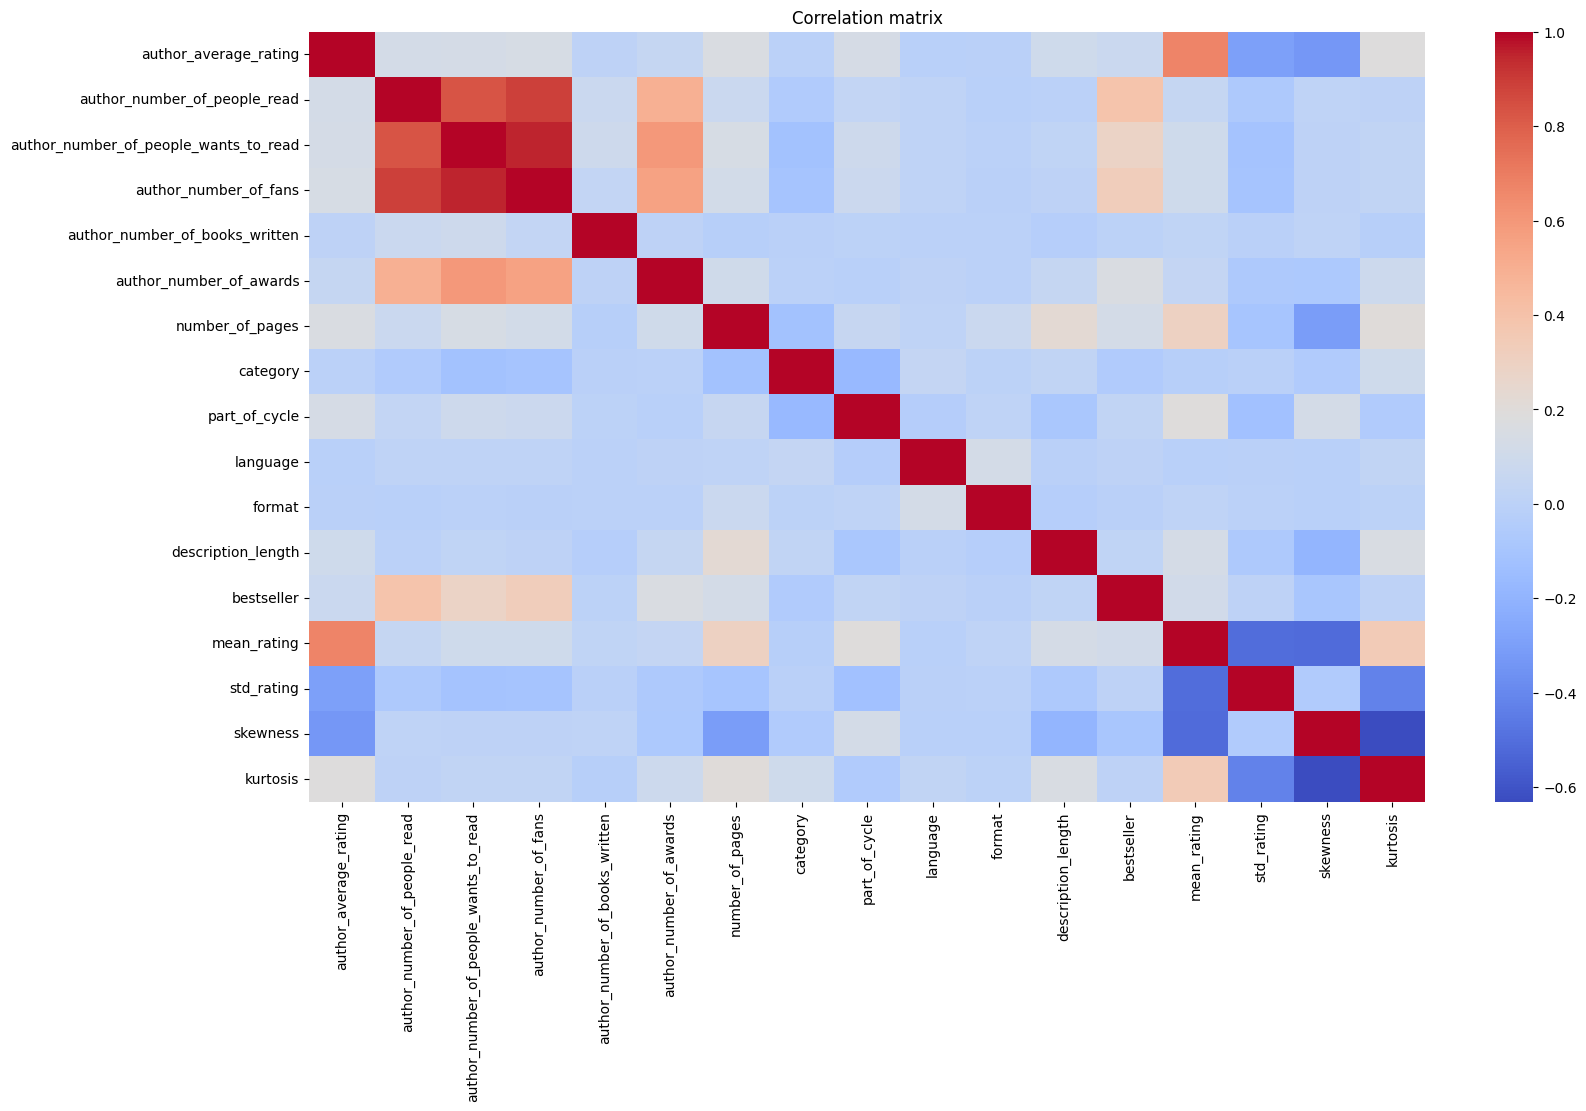

In [19]:
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [20]:
X = data.drop(['bestseller'] + rating_features + normalized_features + scaled_features, axis=1)
y = data['bestseller']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80085666)
print('Train size:', X_train.shape)
print('Test size:', X_test.shape)

Train size: (10626, 16)
Test size: (4555, 16)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import loguniform  # Fix loguniform import
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

# Logistic regression pipeline

In [23]:
number_of_features = X_train.shape[1]
param_dist = [
    {"classifier__C": loguniform(1e-4, 10), "classifier__penalty": ["l1"], "classifier__solver": ["liblinear"], "feature_selection__k": np.arange(1, number_of_features + 1)},
]

log_reg_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('classifier', LogisticRegression(max_iter=10000, class_weight='balanced')),
])

randomized_log_reg = RandomizedSearchCV(
    log_reg_pipeline, param_distributions=param_dist, scoring='recall', n_iter=10, cv=5, verbose=1, n_jobs=-1
)

randomized_log_reg.fit(X_train, y_train)

##


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_selection',
                                              SelectKBest(score_func=<function mutual_info_classif at 0x7f1792e744a0>)),
                                             ('classifier',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=10000))]),
                   n_jobs=-1,
                   param_distributions=[{'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f1792e70980>,
                                         'classifier__penalty': ['l1'],
                                         'classifier__solver': ['liblinear'],
                                         'feature_selection__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])}],
                   scoring='recall', verbose=1)

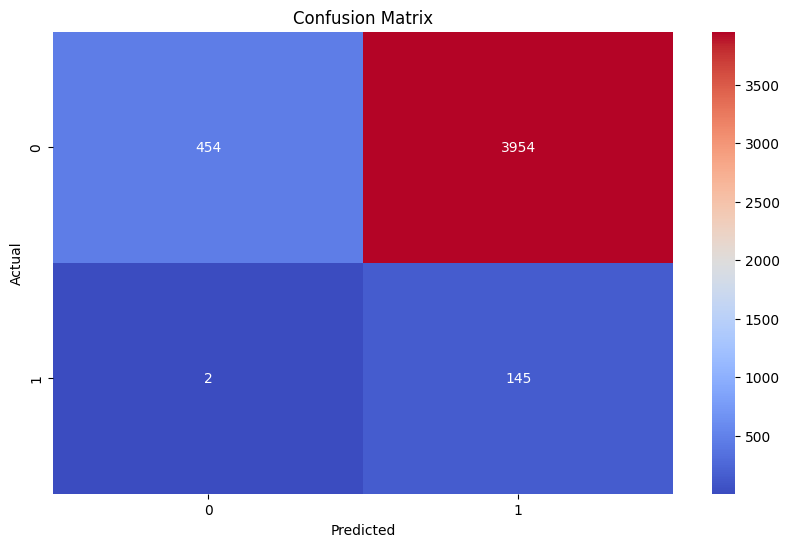

              precision    recall  f1-score   support

           0       1.00      0.10      0.19      4408
           1       0.04      0.99      0.07       147

    accuracy                           0.13      4555
   macro avg       0.52      0.54      0.13      4555
weighted avg       0.96      0.13      0.18      4555



In [25]:
log_y_pred = randomized_log_reg.predict(X_test)
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, log_y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, log_y_pred))

In [71]:
reference_books = pd.read_csv('data/books_data.csv')
reference_books['title'] = reference_books['url'].str.split('/').str[-1].str.split('-').str.join(' ').str.title()
reference_books['number_of_ratings'] = reference_books[rating_features].sum(axis=1)
reference_books.loc[y_test.index[(y_test == 0) & (randomized_log_reg.predict(X_test) == 1)], ['title', 'author', 'number_of_people_has', 'Format', 'number_of_ratings']].sort_values('number_of_people_has', ascending=False).iloc[0:, :].head(30)

/tmp/ipykernel_177945/1594993385.py:1: DtypeWarning: Columns (76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  reference_books = pd.read_csv('data/books_data.csv')


,title,author,number_of_people_has,Format,number_of_ratings
213,Opium W Rosole,Małgorzata Musierowicz,1993.0,papier,12161
773,Zalety Bycia Niewidzialnym,Stephen Chbosky,1990.0,papier,5097
682,Gra Geralda,Stephen King,1979.0,papier,5729
639,Ja Inkwizytor Lowcy Dusz,Jacek Piekara,1965.0,papier,6034
586,Krolowa I Faworytka,Kiera Cass,1956.0,papier,6315
1095,Will Grayson Will Grayson,John Green,1936.0,papier,3995
383,Bez Sladu,Harlan Coben,1931.0,papier,8373
609,1Q84 Tom 1,Haruki Murakami,1922.0,papier,6105
340,Szosta Klepka,Małgorzata Musierowicz,1921.0,papier,8920
686,Florystka,Katarzyna Bonda,1915.0,papier,5832


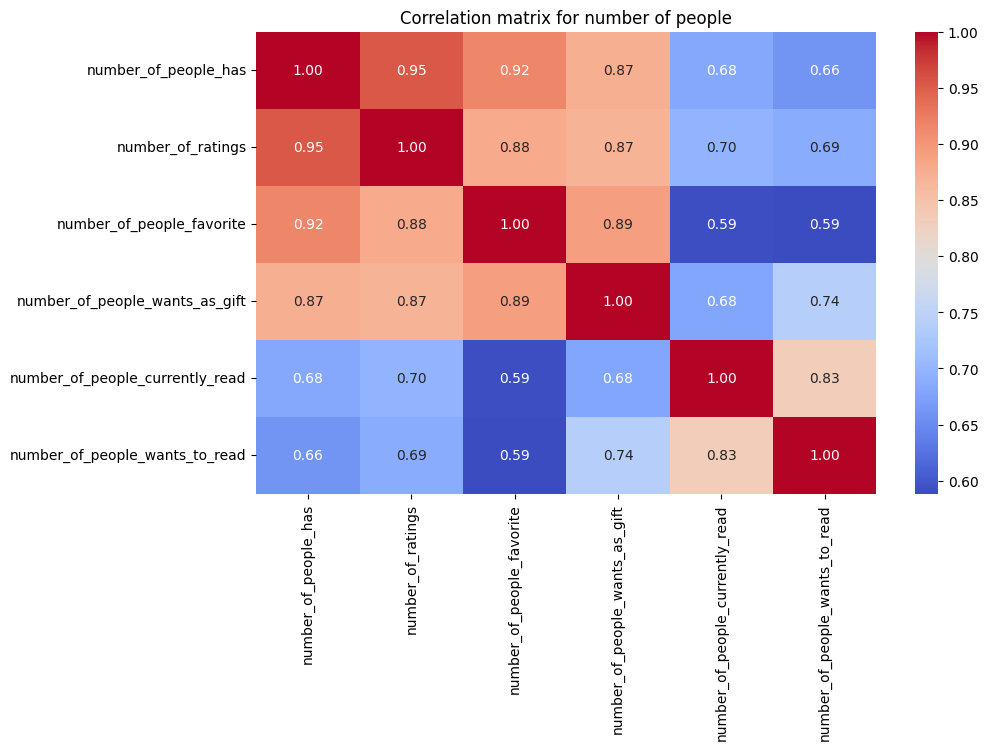

In [84]:
# correlation matrix for number of people use it later

has_correlation = reference_books[['number_of_people_has', 'number_of_ratings', 'number_of_people_favorite', 'number_of_people_wants_as_gift', 'number_of_people_currently_read', 'number_of_people_wants_to_read']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(has_correlation, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix for number of people')
plt.show()

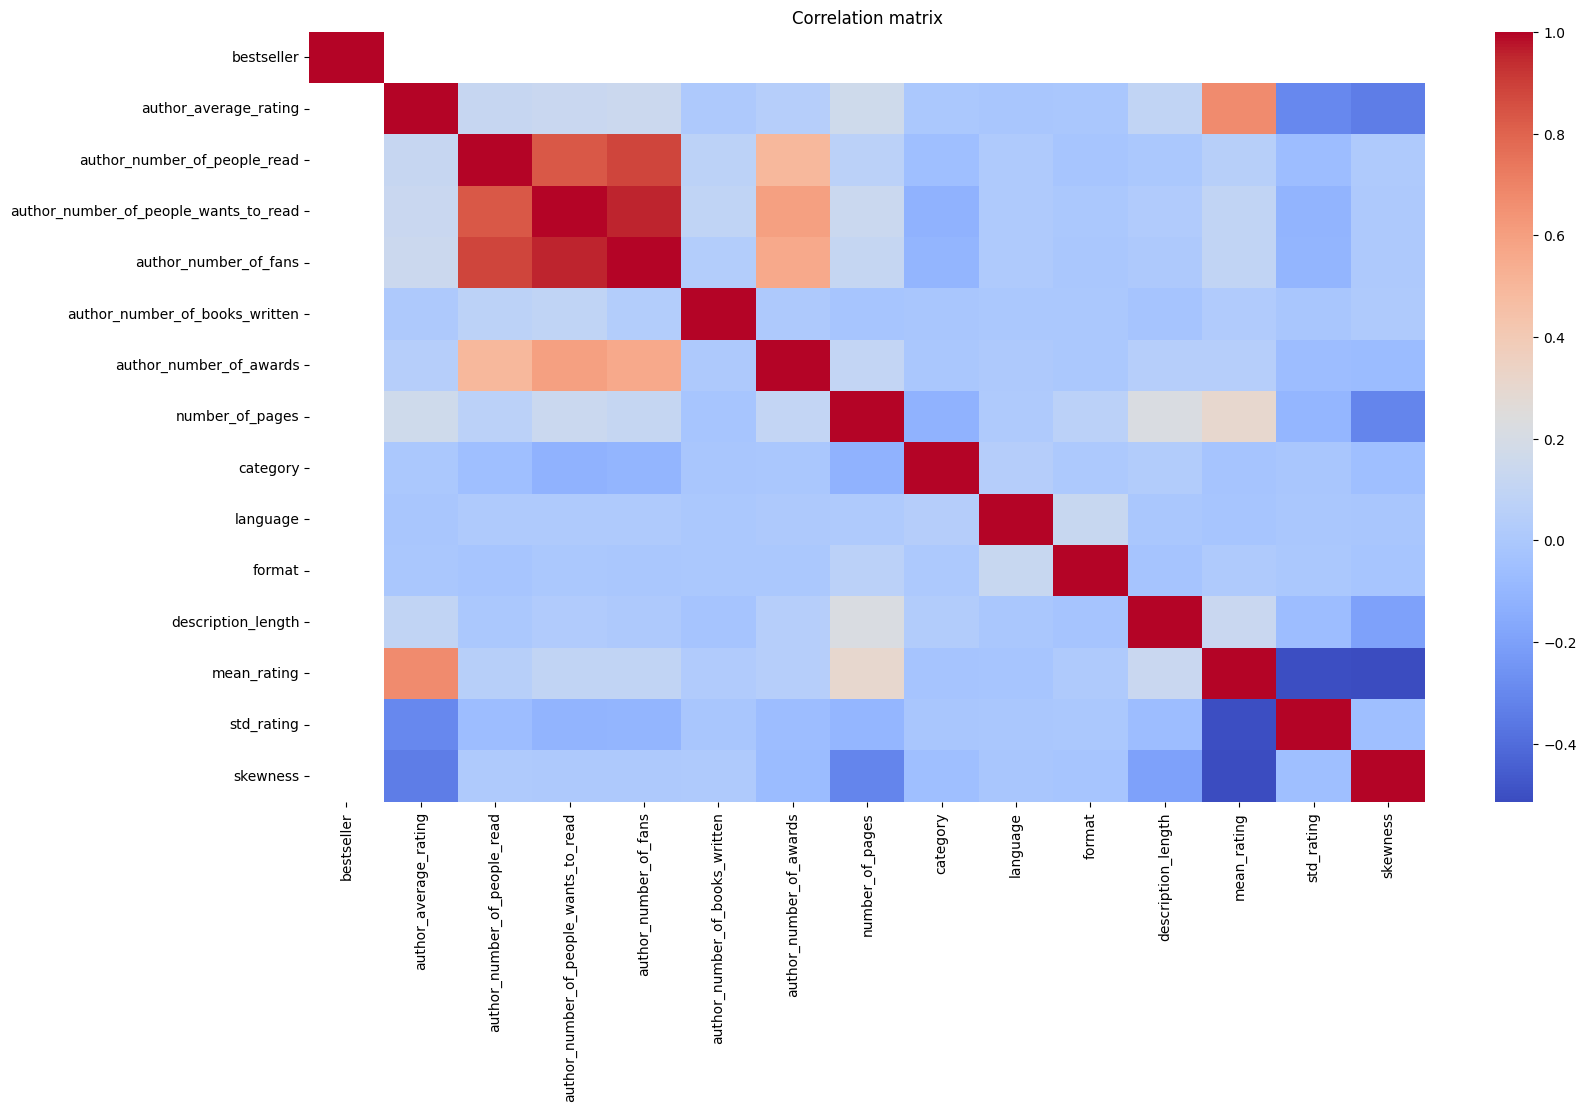

In [296]:
# plot correlation matrix for logistic regression
log_reg_correlation_matrix = pd.concat([data['bestseller'], data[X_train.columns[randomized_log_reg.best_estimator_.named_steps['feature_selection'].get_support()]]]).corr()
plt.figure(figsize=(18, 10))
sns.heatmap(log_reg_correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

# Random forrest pipeline

In [141]:
data.columns

Index(['author_average_rating', 'author_number_of_people_read',
       'author_number_of_people_wants_to_read', 'author_number_of_fans',
       'author_number_of_books_written', 'author_number_of_awards',
       'number_of_pages', 'rating_1', 'rating_2', 'rating_3', 'rating_4',
       'rating_5', 'rating_6', 'rating_7', 'rating_8', 'rating_9', 'rating_10',
       'category', 'part_of_cycle', 'language', 'format', 'description_length',
       'bestseller', 'scaled_rating_1', 'scaled_rating_2', 'scaled_rating_3',
       'scaled_rating_4', 'scaled_rating_5', 'scaled_rating_6',
       'scaled_rating_7', 'scaled_rating_8', 'scaled_rating_9',
       'scaled_rating_10', 'normalized_rating_1', 'normalized_rating_2',
       'normalized_rating_3', 'normalized_rating_4', 'normalized_rating_5',
       'normalized_rating_6', 'normalized_rating_7', 'normalized_rating_8',
       'normalized_rating_9', 'normalized_rating_10', 'mean_rating',
       'std_rating', 'skewness', 'kurtosis'],
      dtype='ob

In [148]:
random_forrest_data = data.drop(['mean_rating', 'std_rating', 'skewness', 'kurtosis'] + rating_features + normalized_features, axis=1)
X_forest = random_forrest_data.drop(['bestseller'], axis=1)
y_forest = random_forrest_data['bestseller']
X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(X_forest, y_forest, test_size=0.7, random_state=80085666)

In [158]:
random_forrest_param_grid = {
    "classifier__n_estimators": [300],  # Slight variation
    "classifier__min_samples_split": [6, 8, 10],  # Neighboring values
    "classifier__min_samples_leaf": [1, 2, 3],  # Smaller range
    "classifier__max_depth": [40, 45]  # Slightly lower/higher
}

# Define the pipeline
random_forrest_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=np.random.seed(80085666))),
])


random_forrest_grid = GridSearchCV(
    random_forrest_pipeline,  # Your existing pipeline
    random_forrest_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="f1",  # Or another relevant metric
    n_jobs=-1,  # Use all CPU cores
    verbose=2
)

random_forrest_grid.fit(X_train_forest, y_train_forest)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END classifier__max_depth=40, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.2s
[CV] END classifier__max_depth=40, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.3s
[CV] END classifier__max_depth=40, classifier__min_samples_leaf=1, classifier__min_samples_split=6, classifier__n_estimators=300; total time=   3.4s
[CV] END classifier__max_depth=40, classifier__min_samples_leaf=1, classifier__min_samples_split=6, classifier__n_estimators=300; total time=   3.8s
[CV] END classifier__max_depth=40, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=300; total time=   3.9s
[CV] END classifier__max_depth=40, classifier__min_samples_leaf=1, classifier__min_samples_split=6, classifier__n_estimators=300; total time=   4.2s
[CV] END classifier__max_depth=40, classifier

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [40, 45],
                         'classifier__min_samples_leaf': [1, 2, 3],
                         'classifier__min_samples_split': [6, 8, 10],
                         'classifier__n_estimators': [300]},
             scoring='f1', verbose=2)

In [159]:
random_forrest_grid.best_params_

{'classifier__max_depth': 45,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 6,
 'classifier__n_estimators': 300}

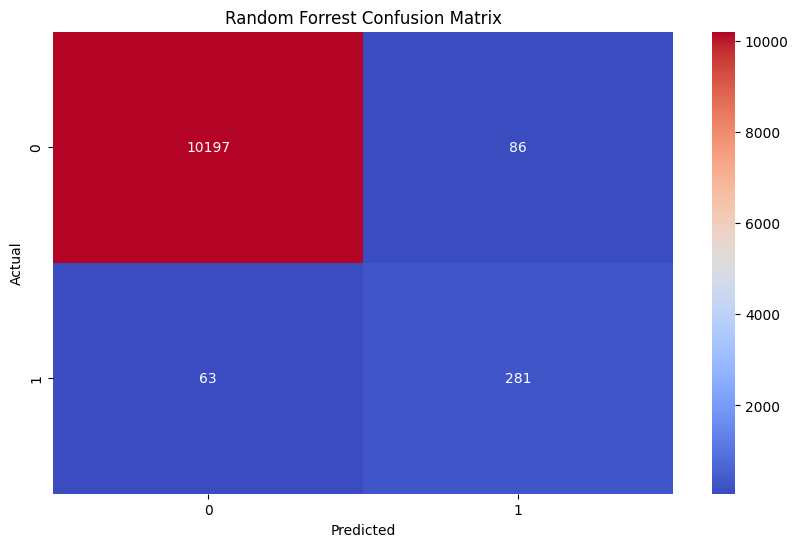

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10283
           1       0.77      0.82      0.79       344

    accuracy                           0.99     10627
   macro avg       0.88      0.90      0.89     10627
weighted avg       0.99      0.99      0.99     10627



In [181]:
random_forest_pred = random_forrest_grid.predict(X_test_forest)
# plot confusion matrix
conf_matrix = confusion_matrix(y_test_forest, random_forest_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forrest Confusion Matrix')
plt.show()
print(classification_report(y_test_forest, random_forest_pred))

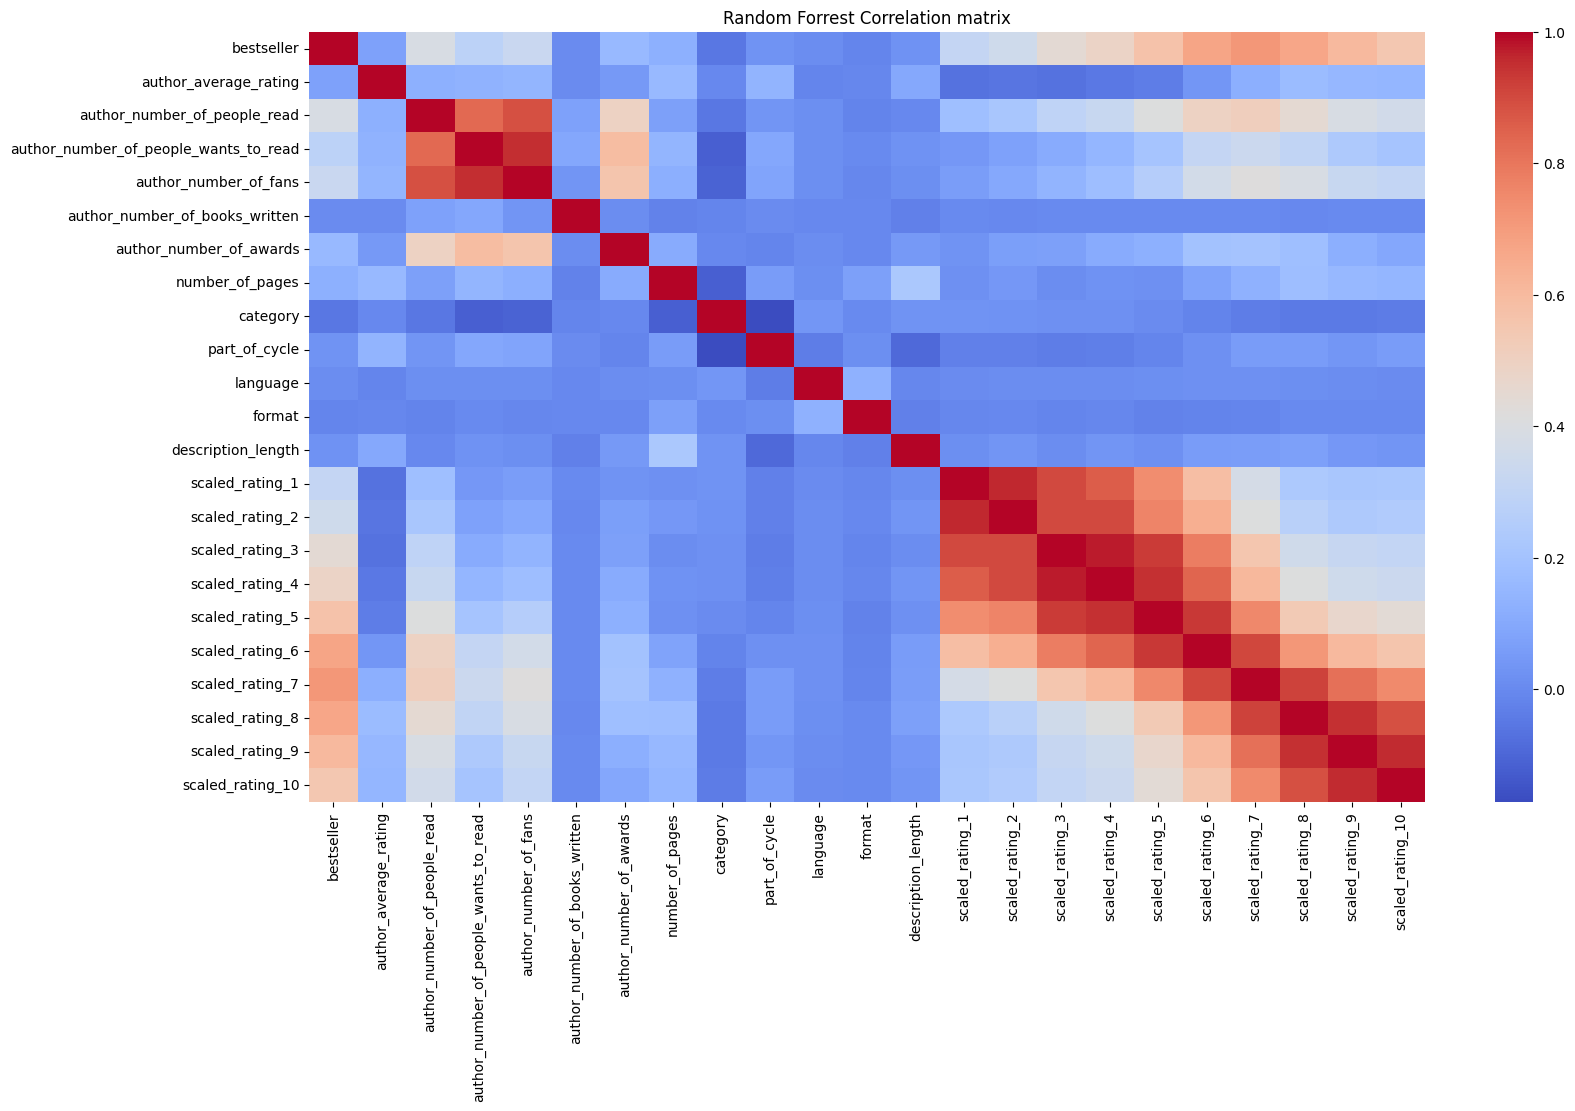

In [286]:
# plot seelcted features correlation matrix
random_forrest_correlation_matrix = pd.concat([data['bestseller'], X_forest], axis=1).corr()
plt.figure(figsize=(18, 10))
sns.heatmap(random_forrest_correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Random Forrest Correlation matrix')
plt.show()

# KNN Pipeline

In [271]:
knn_data = data.drop(['mean_rating', 'std_rating', 'skewness', 'kurtosis']+ normalized_features + scaled_features, axis=1)
X_knn = knn_data.drop(['bestseller'], axis=1)
y_knn = knn_data['bestseller']
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.4, random_state=20010911)

In [277]:
number_of_features_knn = X_train_knn.shape[1]
knn_param_grid = {
    'feature_selection__k': [8, 9, 10],
    'knn__weights': ['distance'],
    'knn__n_neighbors': [4, 5, 6],
    'knn__metric': ['euclidean', 'minkowski'],
    'knn__algorithm': ['auto'],
}

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('knn', KNeighborsClassifier()),
])

knn_grid = GridSearchCV(
    knn_pipeline,  # Your existing pipeline
    knn_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="f1",  # Or another relevant metric
    n_jobs=-1,  # Use all CPU cores
    verbose=2
)

knn_grid.fit(X_train_knn, y_train_knn)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END feature_selection__k=8, knn__algorithm=auto, knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance; total time=   0.1s
[CV] END feature_selection__k=8, knn__algorithm=auto, knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance; total time=   0.1s
[CV] END feature_selection__k=8, knn__algorithm=auto, knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance; total time=   0.1s
[CV] END feature_selection__k=8, knn__algorithm=auto, knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance; total time=   0.2s
[CV] END feature_selection__k=8, knn__algorithm=auto, knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance; total time=   0.1s
[CV] END feature_selection__k=8, knn__algorithm=auto, knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance; total time=   0.2s
[CV] END feature_selection__k=8, knn__algorithm=auto, knn__metric=euclidean, knn__n_neighbors=5, knn__wei

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer()),
                                       ('feature_selection', SelectKBest()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [8, 9, 10],
                         'knn__algorithm': ['auto'],
                         'knn__metric': ['euclidean', 'minkowski'],
                         'knn__n_neighbors': [4, 5, 6],
                         'knn__weights': ['distance']},
             scoring='f1', verbose=2)

In [278]:
knn_model = knn_grid.best_estimator_

In [280]:
# selected features
X_train_knn.columns[knn_model.named_steps['feature_selection'].get_support()]

Index(['rating_3', 'rating_4', 'rating_5', 'rating_6', 'rating_7', 'rating_8',
       'rating_9', 'rating_10'],
      dtype='object')

In [281]:
knn_grid.best_params_

{'feature_selection__k': 8,
 'knn__algorithm': 'auto',
 'knn__metric': 'euclidean',
 'knn__n_neighbors': 6,
 'knn__weights': 'distance'}

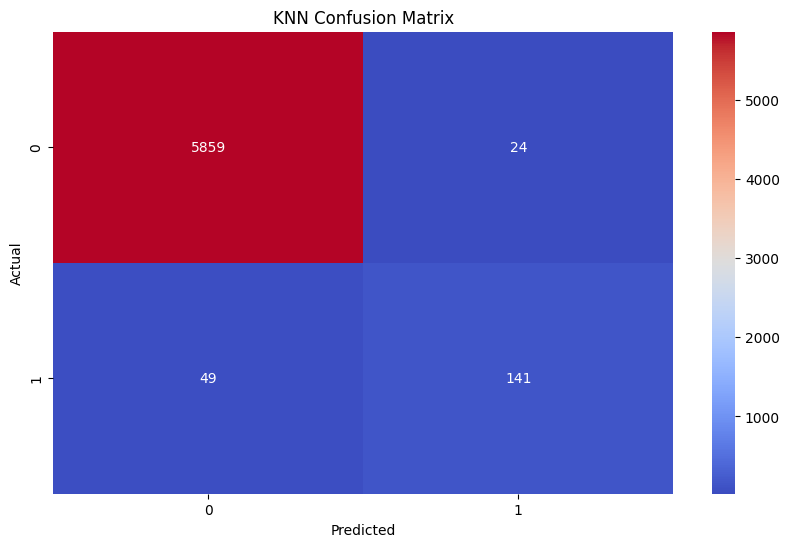

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5883
           1       0.85      0.74      0.79       190

    accuracy                           0.99      6073
   macro avg       0.92      0.87      0.89      6073
weighted avg       0.99      0.99      0.99      6073



In [282]:
knn_pred = knn_model.predict(X_test_knn)
# plot confusion matrix
conf_matrix = confusion_matrix(y_test_knn, knn_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()
print(classification_report(y_test_knn, knn_pred))

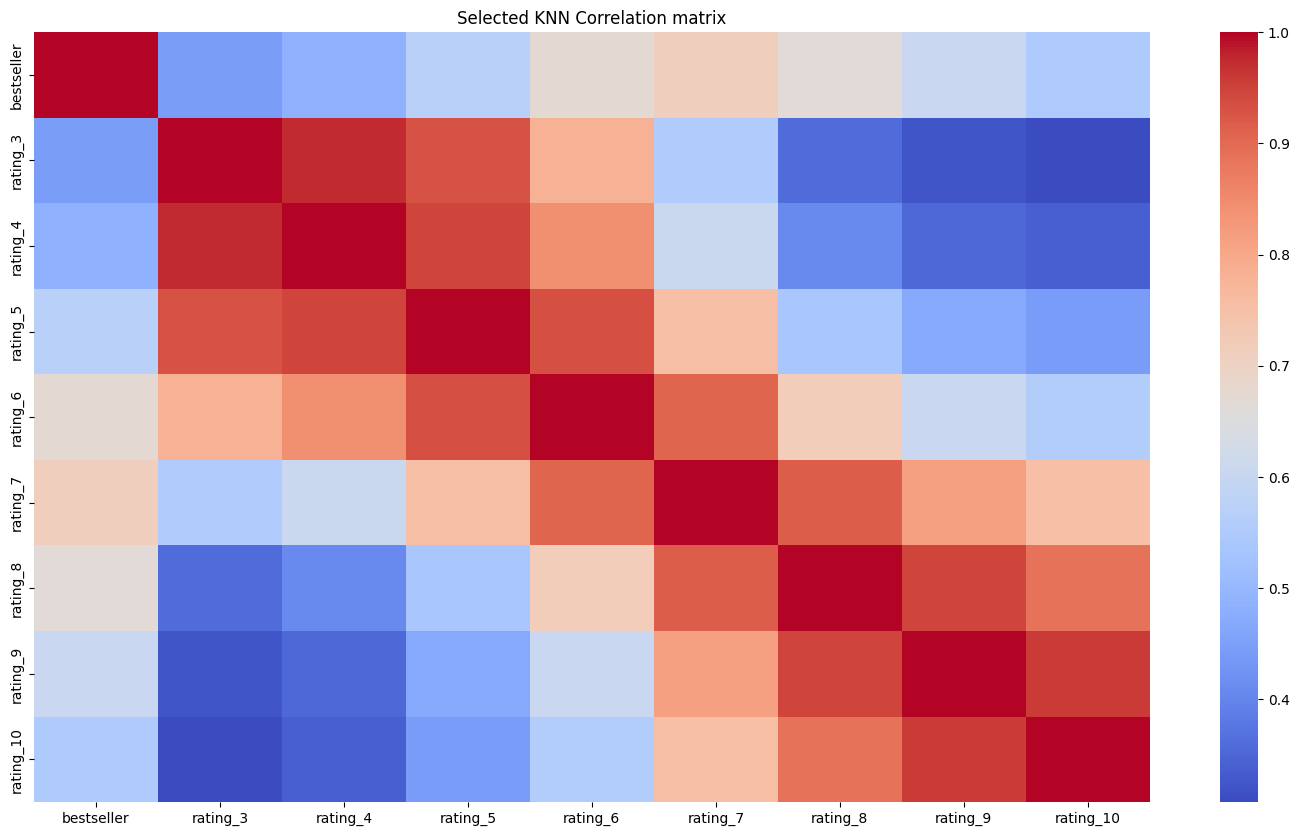

In [285]:
selected_knn_correlation_matrix = pd.concat([data['bestseller'], data[X_train_knn.columns[knn_model.named_steps['feature_selection'].get_support()]]], axis=1).corr()
# plot correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(selected_knn_correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Selected KNN Correlation matrix')
plt.show()

In [100]:
reference_books = pd.read_csv('data/books_data.csv')

/tmp/ipykernel_157347/2771065467.py:1: DtypeWarning: Columns (76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  reference_books = pd.read_csv('data/books_data.csv')


In [101]:
reference_books['title'] = reference_books['url'].str.split('/').str[-1].str.split('-').str.join(' ').str.title()

In [104]:
reference_books.loc[X[(y == 0) & (randomized_log_reg.predict(X) == 1)].index][['title', 'author', 'number_of_people_has']].sort_values('number_of_people_has', ascending=False).tail(20)

,title,author,number_of_people_has
14667,Orso,Henryk Sienkiewicz,32.0
13164,Genezis Z Ducha,Juliusz Słowacki,30.0
7511,Mezczyzni Ktorzy Nienawidza Kobiet Czesc 2,Stieg Larsson,30.0
14603,Cztery Opowiadania List Do Ojca,Franz Kafka,29.0
12005,Opowiadania Zebrane,Gustaw Herling-Grudziński,29.0
15121,Mazepa Tragedia W Pieciu Aktach,Juliusz Słowacki,28.0
13024,Operetka,Witold Gombrowicz,28.0
14429,Krol Duch Rapsod I,Juliusz Słowacki,28.0
11002,Pan Jowialski,Aleksander Fredro,28.0
12582,Malowany Czlowiek Ksiega 2,Peter V. Brett,25.0
